In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

In [2]:
fname = '../Representative_kinases/Rep_kinases_dataset.csv'
df = pd.read_csv(fname,delimiter='\t')
# df.head()
# df.p_standard_type.value_counts()

<Axes: ylabel='Frequency'>

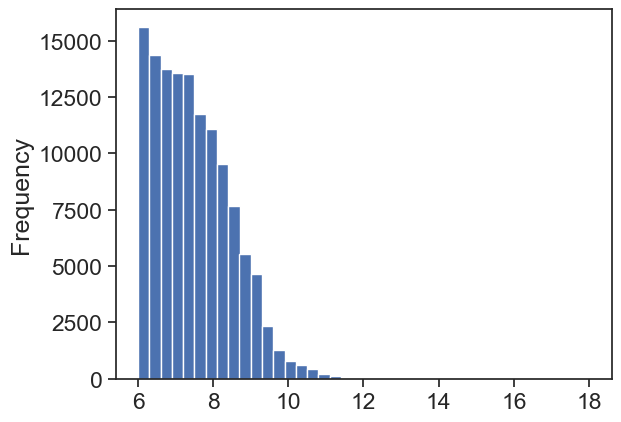

In [28]:
df.p_value.plot(kind='hist',bins=40)

In [71]:
from salsa.utils import get_cansmiles
dff = df[df.p_standard_type=='pIC50']
dff['Smiles'] = dff.NonstereoAromaticSMILES.apply(lambda x: get_cansmiles(x))
all_smis = list(dff.Smiles.unique())
# len(all_smis)
# dff.Kinase_group.value_counts()

dfff = dff[dff.p_value>=8.5]

### Only use select TK kinases.

In [104]:
these = ['JakA','EGFR',
         'FGFR',
#          'VEGFR',
         'Src','PDGFR','Abl','Trk','Tec','ALK'] 
df_tk = dfff[dfff.Kinase_family.isin(these)]
df_tk = df_tk[['Smiles','Kinase_family','Kinase_name']]
df_tk = df_tk.drop_duplicates(keep='first')

In [105]:
from salsa.chef import serve_salsa, store_salsa
# # # # # # # # # # # # # # # # # # # # # # # #
version_to_name = {
#     '60_202307161704':'SALSA-512',
#     '61_202307161704':'Contra-512',
#     '62_202307161704':'Naive-512',
    '63_202307171144':'SALSA-32',
           }

method_to_name = {}
for v in version_to_name.keys():
    df_tk, ls, subv, train_ds = serve_salsa(input_ds=df_tk, model_version=v, use_cuda=[3], 
                                         batch_size=75, df_mode='salsa', weight_dir='keep', 
                                         epoch='00', step=None,print_out=True)
    method_to_name[subv] = version_to_name[v]


Creating DataLoader with (corrected) batch size of 75 ...
Preparing to serve salsa! 63_202307171144 epoch 00 step 69791 ...
 Parameter count: 62,022,279

You have been served salsa! Subversion: 63_202307171144-00-69791


In [106]:
import joblib
import umap.umap_ as umap
import seaborn as sns 
import matplotlib.pylab as plt
from datetime import datetime

for method,name in method_to_name.items():
    if name=='SALSA-512':
        continue
    print(method,name)
    print(f"{method,name}\n")
    umapper = umap.UMAP(n_neighbors=32, 
                        min_dist=0.1, 
                        n_components=2, 
                        metric='euclidean')    
    latents = np.vstack(df_tk[method].values)
    embedding = umapper.fit_transform(latents)

for method,name in method_to_name.items():
    df_tk[f'x_{name}'] = embedding[:,0]
    df_tk[f'y_{name}'] = embedding[:,1]

63_202307171144-00-69791 SALSA-32
('63_202307171144-00-69791', 'SALSA-32')



In [107]:
df_tk[df_tk.Kinase_family=='ALK'].Smiles

197           COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc(C(F)(F)F)c(Nc2ccc(N3CCN(C(C)=O)CC3)cc2OC)n1
198                 COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc(Cl)c(Nc2ccc(N3CCN(C(C)=O)CC3)cc2OC)n1
199                COc1cc(N2CCNCC2)ccc1Nc1ncc(C(F)(F)F)c(Nc2ccc(N3CCN(C(C)=O)CC3)cc2OC)n1
201                         COc1cc(N2CCN(C(C)=O)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2P(C)(C)=O)n1
257                       COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2C(C)=O)n1
258                                   COc1cc(P(C)(C)=O)ccc1Nc1ncc(Cl)c(Nc2ccccc2C(C)=O)n1
819                      COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1nc(Nc2cccc(F)c2C(N)=O)c2cc[nH]c2n1
822     CC(C)NC(=O)C1CCC(n2c(=NC(=O)c3cc(F)cc(F)c3)[nH]c3ccc(CN4CCC(C(C)(C)O)CC4)cc32)CC1
823        CC(C)NC(=O)C1CCC(n2c(=NC(=O)c3ccc(F)cc3)[nH]c3ccc(CN4CCC(C(C)(C)O)CC4)cc32)CC1
824         CC(C)NC(=O)C1CCC(n2c(NC(=O)c3cc(F)cc(F)c3)nc3ccc(CN4CCC(C(C)(C)O)CC4)cc32)CC1
825            CC(C)NC(=O)C1CCC(n2c(NC(=O)c3ccc(F)cc3)nc3ccc(CN4CCC(C(C)(C)O)CC4)cc32)CC1
903       

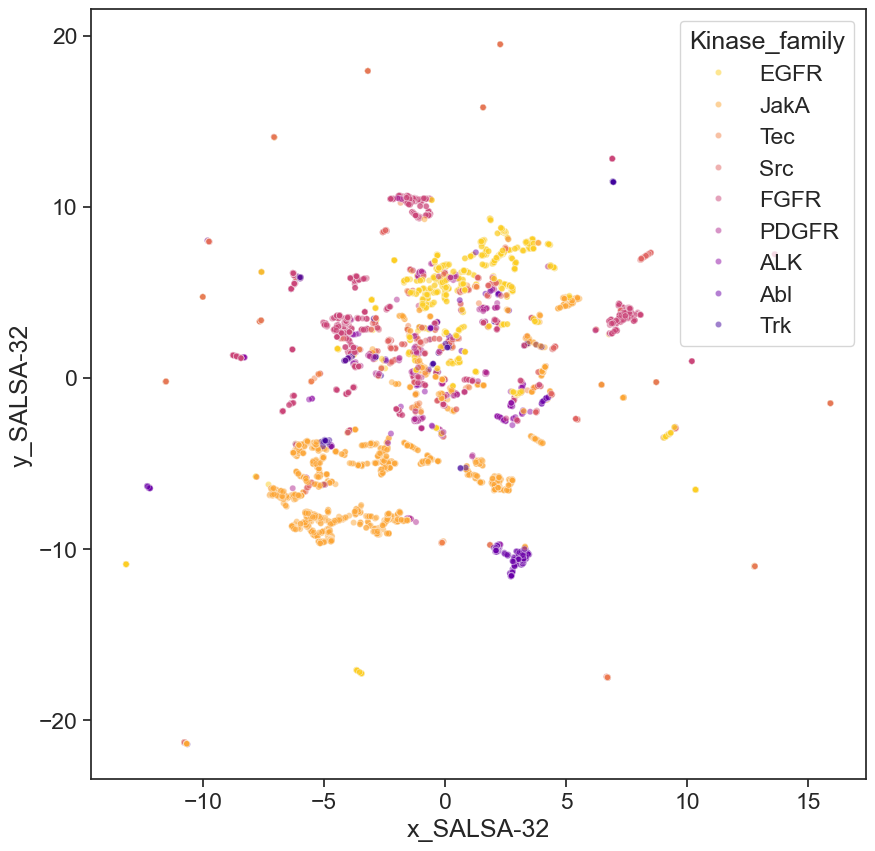

In [108]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_theme(style='ticks',font_scale=1.5) 


plt.figure(figsize=(10,10))
args = {'x':f'x_SALSA-32',
        'y':f'y_SALSA-32'}


sns.scatterplot(data=df_tk, #[df_tk.Kinase_family=='JakA'],
                hue='Kinase_family',
                palette='plasma_r',
                alpha=.5,
                s=20, #s=10, #s=20
                **args, )
plt.show()

In [46]:
dfff[dfff.Kinase_group=='TK'].Kinase_family.value_counts()

Kinase_family
JakA     2160
EGFR     1219
FGFR     1143
VEGFR     925
Src       651
PDGFR     361
Abl       356
Trk       129
Tec       123
ALK       117
FAK        98
Met        55
InsR       46
Syk        41
Axl        40
Tie        39
Ret        39
Sev        32
Eph        27
DDR        13
Csk         3
Fer         3
Ack         2
Name: count, dtype: int64

In [ ]:
# long_smis = [x for x in all_smis if len(x)>=120]
# long_dfff, ls, subv, train_ds = serve_salsa(input_ds=long_smis, model_version=v, use_cuda=[3], 
#                                             batch_size=75, df_mode='salsa', weight_dir='keep', 
#                                             epoch='00', step=None, print_out=True)